In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Add files up one level to the path
import sys
sys.path.append("..")

import jlinops

from solvers import MMGKS

# Toy problem

In [9]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.1
noise_var = noise_stdev**2
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=10, mode="reflect")
#A = jlinops.IdentityOperator((n,n))
noisy_signal = A.matvec(ground_truth) + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

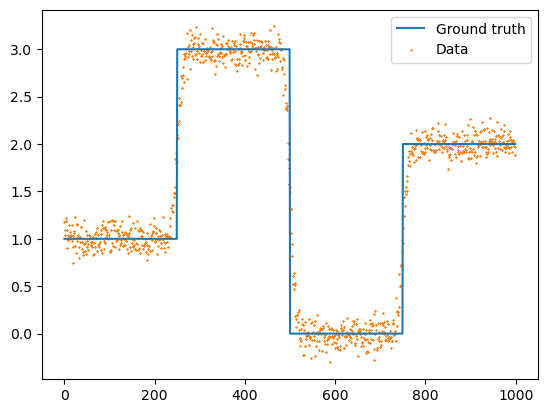

In [10]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Define regularization

In [11]:
Lmat, Wmat = jlinops.first_order_derivative_1d(n, boundary="none")
L = jlinops.MatrixLinearOperator(Lmat) # Cast sparse matrix R as a linear operator

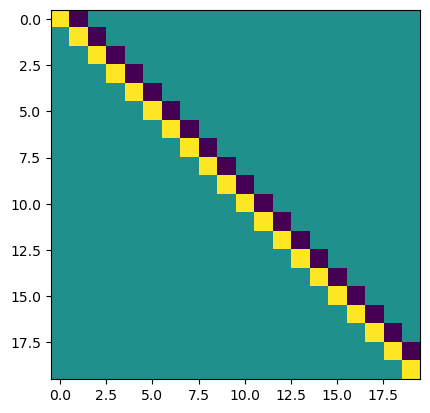

In [12]:
plt.imshow(Lmat.toarray()[:20,:20])
plt.show()

# Set up methods for comparison (first do convex case)

In [13]:
# TRIPs-Py methods are dp and gcv. The rest I have added. I believe dp is the same as dp3, except uses the GSVD in the formulation of the method whereas dp3 avoids using a GSVD.
methods = ["dp", "dp2", "dp3", "mgcv", "gcv", "matlab_gcv", "mgcv_no_whitening", "gcv_no_whitening", "matlab_gcv_no_whitening" ]
print(f"Number of methods to compare: {len(methods)}")

Number of methods to compare: 9


In [15]:
# Set problem parameters
n_iters = 250
q = 1.0
epsilon = 1e-2

# Build a dictionary containg solvers and solver results
comp_dct = {}

# Iterate over methods
for method in methods:
    print(f"Started method: {method}")

    # Build solver
    if (method == "mgcv_no_whitening") or (method == "gcv_no_whitening") or (method == "matlab_gcv_no_whitening"):
        mmgks_solver = MMGKS(A, L, noisy_signal, noise_var=None)
    else:
        mmgks_solver = MMGKS(A, L, noisy_signal, noise_var=noise_var)

    # Processing for regparam method
    if (method == "mgcv_no_whitening"):
        regparam = "mgcv"
    elif (method == "gcv_no_whitening"):
        regparam = "gcv"
    elif (method == "matlab_gcv_no_whitening"):
        regparam = "matlab_gcv"
    else:
        regparam = method

    # Run solver
    data = mmgks_solver.solve(n_iter=n_iters, q=q, epsilon=epsilon, x_true=ground_truth, regparam=regparam)


    # Put results into dict
    comp_dct[method] = data

Started method: dp


Started method: dp2


Started method: dp3


Started method: mgcv


Started method: gcv


Started method: matlab_gcv


Started method: mgcv_no_whitening


Started method: gcv_no_whitening


Started method: matlab_gcv_no_whitening


# Comparison plots

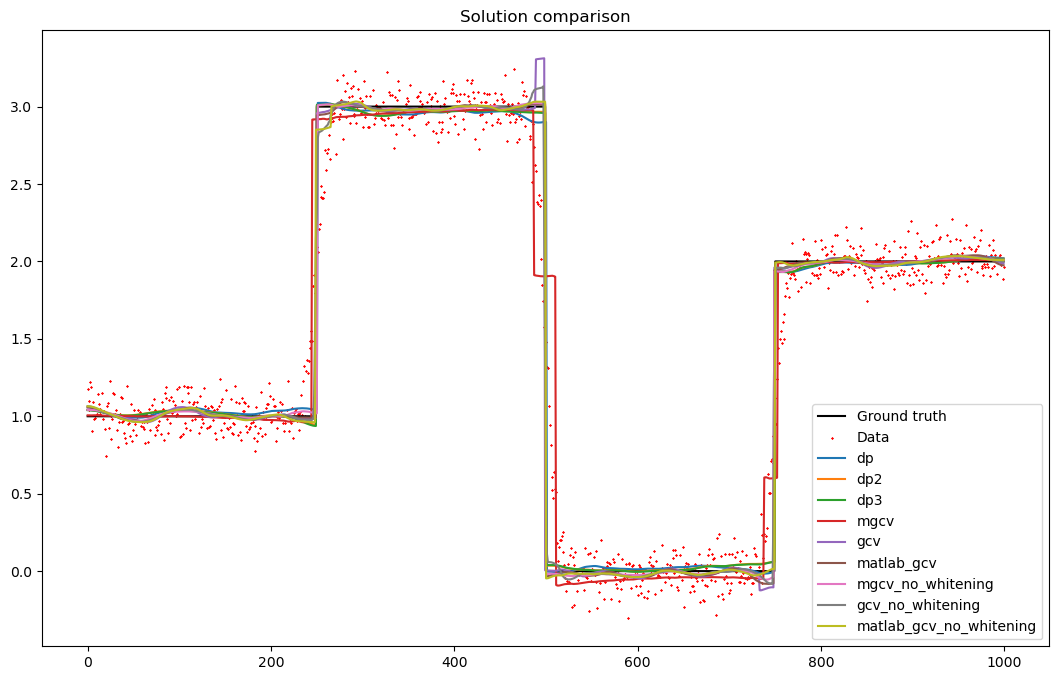

In [16]:
plt.figure(figsize=(13,8))

plt.plot(grid, ground_truth, label="Ground truth", color="black")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="red", alpha=1.0, s=0.5)

for method in comp_dct.keys():
    data = comp_dct[method]
    plt.plot(grid, data["x"], label=method)

plt.legend(loc="lower right")
plt.title("Solution comparison")
plt.show()

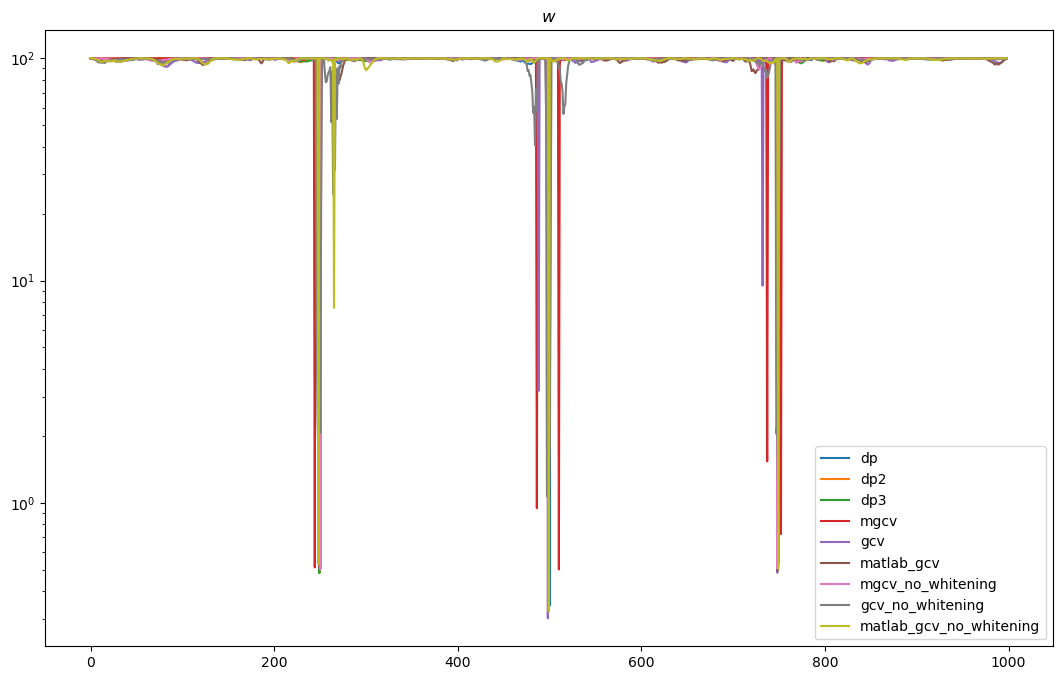

In [20]:
plt.figure(figsize=(13,8))


for method in comp_dct.keys():
    data = comp_dct[method]
    plt.semilogy(grid[:-1], data["w"], label=method)

plt.legend(loc="lower right")
plt.title("$w$")
plt.show()

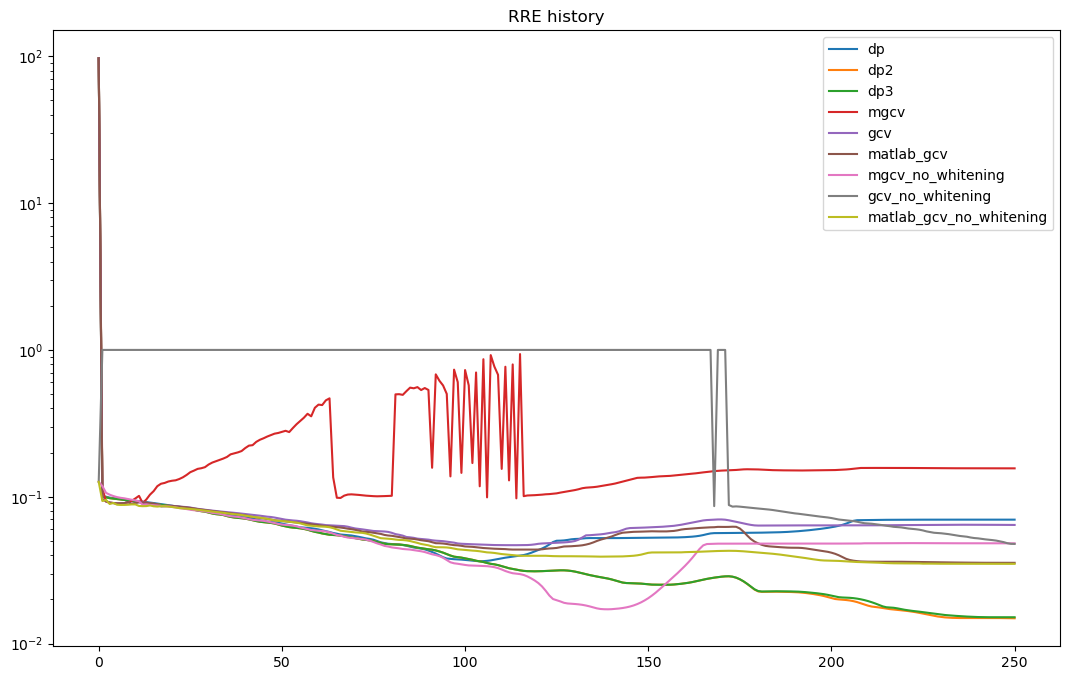

In [21]:
plt.figure(figsize=(13,8))


for method in comp_dct.keys():
    data = comp_dct[method]
    plt.semilogy(data["rre_history"], label=method)

plt.legend(loc="upper right")
plt.title("RRE history")
plt.show()

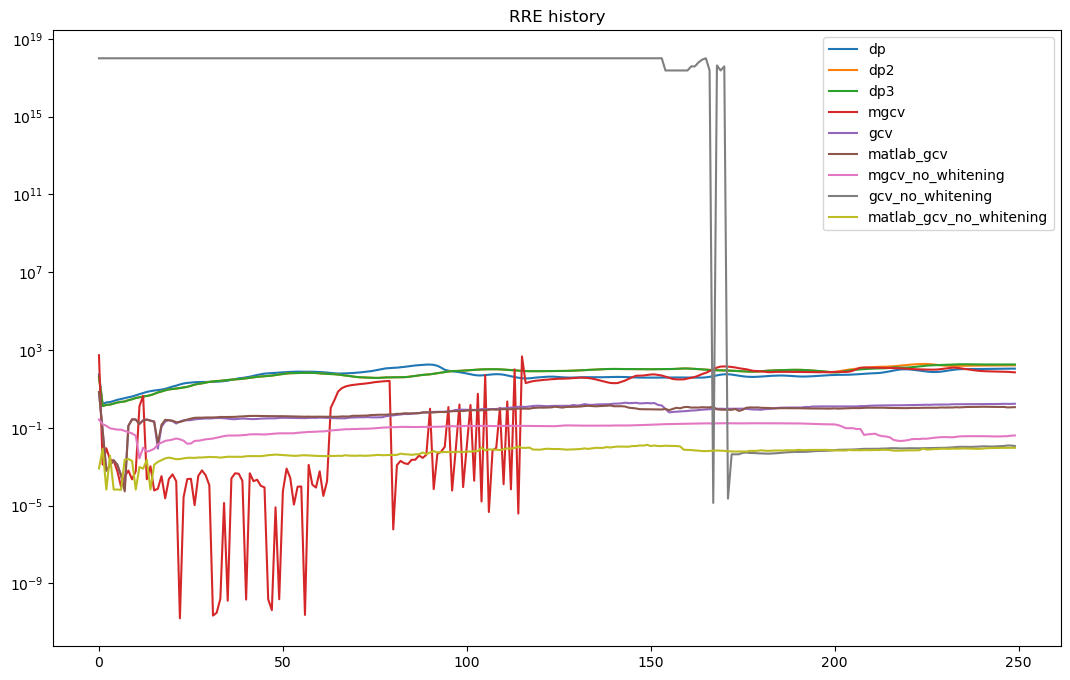

In [22]:
plt.figure(figsize=(13,8))


for method in comp_dct.keys():
    data = comp_dct[method]
    plt.semilogy(data["lambda_history"], label=method)

plt.legend(loc="upper right")
plt.title("RRE history")
plt.show()